In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

words = open("names.txt").read().splitlines()

letters = sorted(list(set(''.join(words)))) #all letters from words

stoi = {l:i+1 for i, l in enumerate(letters)}
stoi['.'] = 0 #add '.' as start or end of the word
itos = {i:l for l, i in stoi.items()}

num_letters = len(stoi)
block_size = 3

In [3]:
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+'.':
            xs.append(context)
            nextInd = stoi[ch]
            ys.append(nextInd)
            context = context[1:]+[nextInd]
            
    return torch.tensor(xs), torch.tensor(ys)

random.seed(42)
random.shuffle(words)

ind1 = int(0.8*len(words))
ind2 = int(0.9*len(words))

x_tr, y_tr = build_dataset(words[:ind1])
x_dev, y_dev = build_dataset(words[ind1:ind2])
x_test, y_test = build_dataset(words[ind2:])

In [43]:
g = torch.Generator().manual_seed(2147483647)

num_emb = 10
num_hidden = 500
num_h = num_emb*block_size
tanh_normal = (5/3) / num_h**0.5

C = torch.randn((num_letters, num_emb), generator=g)
W1 = torch.randn((num_h, num_hidden), generator=g) * tanh_normal
# torch.nn.init.kaiming_normal_(W1, nonlinearity='tanh')
# b1 = torch.randn(num_hidden, generator=g) * 0.01
W2 = torch.randn((num_hidden, num_letters), generator=g) * 0.01
b2 = torch.zeros(num_letters)

batch_normal_gain = torch.ones((1, num_hidden))
batch_normal_bias = torch.zeros((1, num_hidden)) # instead of b1

batch_mean_running = torch.zeros((1, num_hidden))
batch_std_running = torch.ones((1, num_hidden))

parameters = [C, W1, W2, b2, batch_normal_gain, batch_normal_bias]

for p in parameters:
    p.requires_grad = True

2.031818389892578


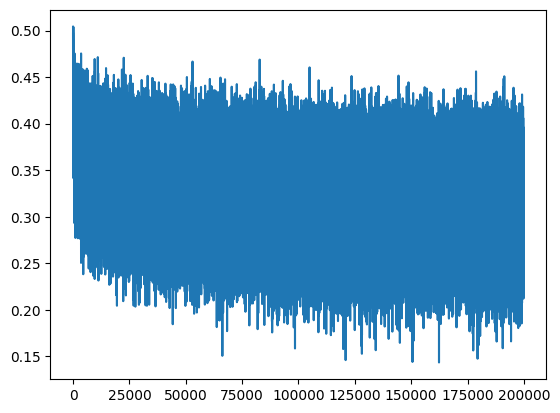

In [48]:
# lrs = []
steps = []
losses = []

epoch=200000
batch_size=50
learning_rate=0.05

# lre = torch.linspace(0.1, 0.001, epoch)
momentum = 0.001

for i in range(epoch):
    # minibatch construct
    inds = torch.randint(0, x_tr.shape[0], (batch_size,))
    x_b, y_b = x_tr[inds], y_tr[inds]
    
    emb = C[x_b] # shape: batch_size, block_size, num_emb
    embcat = emb.view(emb.shape[0], -1) # shape: (batch_size, num_h)
    
    # forward pass
    h_preact = embcat @ W1 # linear hidden layer, shape: (batch_size, num_h) @ (num_h, num_hidden) + num_hidden = (batch_size, num_hidden)
    h_mean = h_preact.mean(0, keepdim=True)
    h_std = h_preact.std(0, keepdim=True)
    h_preact_normal = batch_normal_gain * (h_preact - h_mean) / h_std + batch_normal_bias # batch normalization, scale and shift
    h = torch.tanh(h_preact_normal) # hidden layer activation
    
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y_b)
    # print(loss.item())

    with torch.no_grad():
        batch_mean_running = (1-momentum) * batch_mean_running + momentum * h_mean
        batch_std_running = (1-momentum) * batch_std_running + momentum * h_std
        
    # backward pass
    for p in parameters:
        p.grad = None # set to zero the gradient
        
    loss.backward()
    
    # update
    # learning_rate = lre[i]
    for p in parameters:
        p.data -= learning_rate * p.grad
        
    # track
    # lrs.append(learning_rate)
    steps.append(i)
    losses.append(loss.log10().item())
    
print(loss.item())
plt.plot(steps, losses)

# plt.hist(hidden_layer.view(-1).tolist(), 50)
# plt.figure(figsize=(20,10))
# plt.imshow(hidden_layer.abs() > 0.99, cmap='gray', interpolation='nearest')

In [49]:
@torch.no_grad() # no grad tracking
def get_loss(data):
    x, y = {
        'train': (x_tr, y_tr),
        'dev': (x_dev, y_dev),
        'test': (x_test, y_test)
    }[data]
        
    emb = C[x]
    h_preact = emb.view(emb.shape[0], -1) @ W1 # + b1
    # h_mean = hidden_layer_preact.mean(0, keepdim=True)
    # h_std = hidden_layer_preact.std(0, keepdim=True)
    h_preact_normal = batch_normal_gain * (h_preact - batch_mean_running) / batch_std_running + batch_normal_bias
    h = torch.tanh(h_preact_normal)
        
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(data, loss.item())

get_loss('train')
get_loss('dev')

train 2.04407000541687
dev 2.1323318481445312


In [52]:
def generateName(g):
    result = ''
    ind = 0
    context = [0] * block_size 
    
    while True:
        # emb = C[torch.tensor([context])] # shape: (1, block_size, num_emb)
        emb = C[context] # shape: (block_size,num_emb)
        h_preact = emb.view(1, -1) @ W1  # shape: (1,num_h) @ (num_h,num_hidden) + num_hidden = 1,num_hidden
        
        h_preact_normal = batch_normal_gain * (h_preact - batch_mean_running) / batch_std_running + batch_normal_bias
        h = torch.tanh(h_preact_normal)
    
        logits = h @ W2 + b2 # shape: (1,num_hidden) @ (num_hidden,num_letters) + num_letters = (1,num_letters)
        probs = F.softmax(logits, dim=1)

        ind = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ind == 0: break
        result += itos[ind]
        context = context[1:]+[ind]

    return result

g = torch.Generator().manual_seed(21474836327)
for _ in range(10):
    print(generateName(g))

holanir
sam
yasha
rashanetu
graith
desreena
rellasia
arra
kiah
creselen
